In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import os


from core.data import load_from_kaggle
from sklearn.model_selection import train_test_split

In [52]:
df = pd.read_csv("../data/raw/loan-default-dataset/loan_default.csv")

In [53]:
# Create missingness flags
missing_cols = [
    'Interest_rate_spread',
    'rate_of_interest',
    'Upfront_charges',
    'dtir1',
    'property_value',
    'LTV'
]

for col in missing_cols:
    df[f'{col}_missing'] = df[col].isna().astype(int)


In [54]:
# train-test-split
# Features and target
features = df.drop(columns=['Status'])
target = df['Status']

# Train / test split
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1,
    random_state=42,
    stratify=target
)

In [55]:
# function for data preparation of the train features containing oulier mask creation and missing values imputation 

def prepare_features_train(features_train):
    """
    Prepare training features:
    - IQR-based outlier flags (1.5 × IQR)
    - Median imputation for selected numeric variables
    - Mode imputation for selected categorical variables

    Returns:
    - prepared_features_train
    - iqr_bounds (to reuse on test data)
    """

    X = features_train.copy()

    # -----------------------------
    # 1. IQR-based outlier flags
    # -----------------------------
    iqr_outlier_vars = [
        'loan_amount',
        'LTV',
        'dtir1',
        'income',
        'property_value',
        'Credit_Score'
    ]

    iqr_bounds = {}

    for col in iqr_outlier_vars:
        series = X[col].dropna()

        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        iqr_bounds[col] = {
            'lower': lower,
            'upper': upper
        }

        X[f'{col}_iqr_outlier'] = (
            (X[col] < lower) | (X[col] > upper)
        ).astype(int)

    # -----------------------------
    # 2. Median imputation (numeric)
    # -----------------------------
    num_impute_cols = [
        'income',
        'term',
        'dtir1',
        'property_value',
        'LTV',
        'Interest_rate_spread',
        'rate_of_interest',
        'Upfront_charges'
    ]

    num_impute_values = {}

    for col in num_impute_cols:
        median_val = X[col].median()
        num_impute_values[col] = median_val
        X[col] = X[col].fillna(median_val)

    # -----------------------------
    # 3. Mode imputation (categorical)
    # -----------------------------
    cat_impute_cols = [
        'loan_limit',
        'approv_in_adv',
        'submission_of_application',
        'age',
        'loan_purpose',
        'Neg_ammortization'
    ]

    cat_impute_values = {}

    for col in cat_impute_cols:
        mode_val = X[col].mode(dropna=True)[0]
        cat_impute_values[col] = mode_val
        X[col] = X[col].fillna(mode_val)

    return X, iqr_bounds, num_impute_values, cat_impute_values


In [56]:
features_train_prepared, iqr_bounds, num_impute_values, cat_impute_values = (
    prepare_features_train(features_train)
)


In [57]:
# Check new outlier flags
[c for c in features_train_prepared.columns if c.endswith('_iqr_outlier')]


['loan_amount_iqr_outlier',
 'LTV_iqr_outlier',
 'dtir1_iqr_outlier',
 'income_iqr_outlier',
 'property_value_iqr_outlier',
 'Credit_Score_iqr_outlier']

In [58]:
# Confirm no missing values in imputed columns
features_train_prepared[
    ['income', 'term', 'dtir1', 'property_value', 'LTV',
     'loan_limit', 'approv_in_adv', 'submission_of_application',
     'age', 'loan_purpose', 'Neg_ammortization', 'Interest_rate_spread', 
     'rate_of_interest','Upfront_charges']
].isna().sum()


income                       0
term                         0
dtir1                        0
property_value               0
LTV                          0
loan_limit                   0
approv_in_adv                0
submission_of_application    0
age                          0
loan_purpose                 0
Neg_ammortization            0
Interest_rate_spread         0
rate_of_interest             0
Upfront_charges              0
dtype: int64

In [59]:
# function for data preparation of the train features: oulier mask creation and missing values imputation 
def prepare_features_test(
    features_test,
    iqr_bounds,
    num_impute_values,
    cat_impute_values
):
    """
    Prepare test features using TRAIN statistics only:
    - IQR-based outlier flags using TRAIN bounds
    - Median imputation using TRAIN medians
    - Mode imputation using TRAIN modes

    Returns:
    - prepared_features_test
    """

    X = features_test.copy()

    # -----------------------------
    # 1. IQR-based outlier flags
    # -----------------------------
    for col, bounds in iqr_bounds.items():
        lower = bounds['lower']
        upper = bounds['upper']

        X[f'{col}_iqr_outlier'] = (
            (X[col] < lower) | (X[col] > upper)
        ).astype(int)

    # -----------------------------
    # 2. Median imputation (numeric)
    # -----------------------------
    for col, median_val in num_impute_values.items():
        X[col] = X[col].fillna(median_val)

    # -----------------------------
    # 3. Mode imputation (categorical)
    # -----------------------------
    for col, mode_val in cat_impute_values.items():
        X[col] = X[col].fillna(mode_val)

    return X

In [60]:
features_test_prepared = prepare_features_test(
    features_test,
    iqr_bounds=iqr_bounds,
    num_impute_values=num_impute_values,
    cat_impute_values=cat_impute_values
)


In [61]:
# Same number of columns?
set(features_train_prepared.columns) == set(features_test_prepared.columns)


True

In [62]:
# No missing values in imputed columns?
features_test_prepared[
    list(num_impute_values.keys()) + list(cat_impute_values.keys())
].isna().sum()


income                       0
term                         0
dtir1                        0
property_value               0
LTV                          0
Interest_rate_spread         0
rate_of_interest             0
Upfront_charges              0
loan_limit                   0
approv_in_adv                0
submission_of_application    0
age                          0
loan_purpose                 0
Neg_ammortization            0
dtype: int64

In [63]:
pd.DataFrame(
    {
        "Data Types": features_train_prepared.dtypes,
        "Missing Values": features_train_prepared.isnull().sum(),
        "Unique Values": features_train_prepared.nunique(),
        "Sample Values": [features_train_prepared[col].sample(3).tolist() for col in features_train_prepared.columns]
    })

,Data Types,Missing Values,Unique Values,Sample Values
ID,int64,0,133803,"[105848, 122647, 121511]"
year,int64,0,1,"[2019, 2019, 2019]"
loan_limit,object,0,2,"[cf, ncf, cf]"
Gender,object,0,4,"[Joint, Sex Not Available, Sex Not Available]"
approv_in_adv,object,0,2,"[nopre, nopre, nopre]"
loan_type,object,0,3,"[type1, type1, type1]"
loan_purpose,object,0,4,"[p3, p4, p4]"
Credit_Worthiness,object,0,2,"[l1, l1, l1]"
open_credit,object,0,2,"[nopc, nopc, nopc]"
business_or_commercial,object,0,2,"[nob/c, nob/c, b/c]"


In [64]:
### Baseline model -  logistic regression


# Columns selection
# Columns to drop
drop_cols = ['ID', 'year', 'Security_Type']

# Numeric features (scaled)
baseline_numeric = [
    'loan_amount',
    'term',
    'income',
    'property_value',
    'LTV',
    'dtir1',
    'Credit_Score',
    'Interest_rate_spread_missing',
    'rate_of_interest_missing',
    'Upfront_charges_missing'
]

# Flag features (NOT scaled)
baseline_flags = [
    'dtir1_missing',
    'property_value_missing',
    'LTV_missing'
]

# Categorical features (one-hot encoded)
baseline_categorical = [
    'loan_limit',
    'approv_in_adv',
    'loan_type',
    'loan_purpose',
    'Credit_Worthiness',
    'open_credit',
    'business_or_commercial',
    'Neg_ammortization',
    'interest_only',
    'lump_sum_payment',
    'construction_type',
    'occupancy_type',
    'Secured_by',
    'total_units',
    'credit_type',
    'co-applicant_credit_type',
    'age',
    'submission_of_application',
    'Region'
]

In [65]:
X_train = features_train_prepared.drop(columns=drop_cols)
X_test  = features_test_prepared.drop(columns=drop_cols)

y_train = target_train
y_test  = target_test

In [66]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), baseline_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), baseline_categorical),
        ('flag', 'passthrough', baseline_flags)
    ]
)


In [67]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

baseline_model = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('clf', LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ))
    ]
)

In [68]:
baseline_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [69]:
y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

In [70]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11203
           1       1.00      1.00      1.00      3664

    accuracy                           1.00     14867
   macro avg       1.00      1.00      1.00     14867
weighted avg       1.00      1.00      1.00     14867



In [71]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

cm_df


,Predicted 0,Predicted 1
Actual 0,11203,0
Actual 1,0,3664


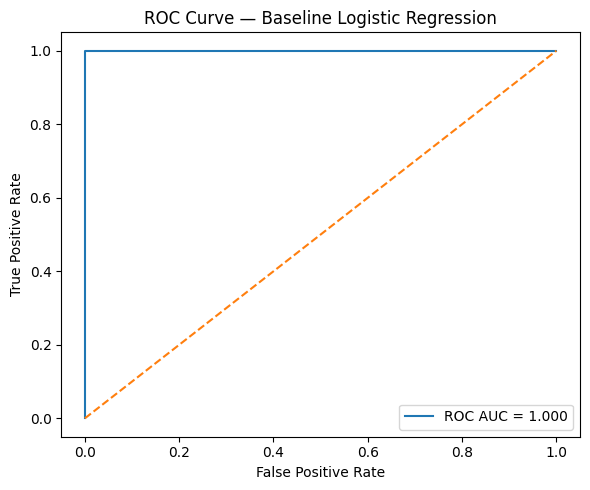

In [72]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Baseline Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
### Baseline model -  logistic regression with 'Interest_rate_spread', 'rate_of_interest', 'Upfront_charges' missingness flags removed



# Columns selection
# Columns to drop
drop_cols = ['ID', 'year', 'Security_Type']

# Numeric features (scaled)
baseline_numeric = [
    'loan_amount',
    'term',
    'income',
    'property_value',
    'LTV',
    'dtir1',
    'Credit_Score'
]

# Flag features (NOT scaled)
baseline_flags = [
    'dtir1_missing',
    'property_value_missing',
    'LTV_missing'
]

# Categorical features (one-hot encoded)
baseline_categorical = [
    'loan_limit',
    'approv_in_adv',
    'loan_type',
    'loan_purpose',
    'Credit_Worthiness',
    'open_credit',
    'business_or_commercial',
    'Neg_ammortization',
    'interest_only',
    'lump_sum_payment',
    'construction_type',
    'occupancy_type',
    'Secured_by',
    'total_units',
    'credit_type',
    'co-applicant_credit_type',
    'age',
    'submission_of_application',
    'Region'
]


In [74]:
X_train = features_train_prepared.drop(columns=drop_cols)
X_test  = features_test_prepared.drop(columns=drop_cols)

y_train = target_train
y_test  = target_test


In [75]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), baseline_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), baseline_categorical),
        ('flag', 'passthrough', baseline_flags)
    ]
)


In [76]:
baseline_model = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('clf', LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ))
    ]
)


In [77]:
baseline_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [78]:
y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]


In [79]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8317078092419452
Recall: 0.6623908296943232
F1-score: 0.6598694942903752
ROC AUC: 0.8429140354248531

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11203
           1       0.66      0.66      0.66      3664

    accuracy                           0.83     14867
   macro avg       0.77      0.77      0.77     14867
weighted avg       0.83      0.83      0.83     14867



In [80]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

cm_df


,Predicted 0,Predicted 1
Actual 0,9938,1265
Actual 1,1237,2427


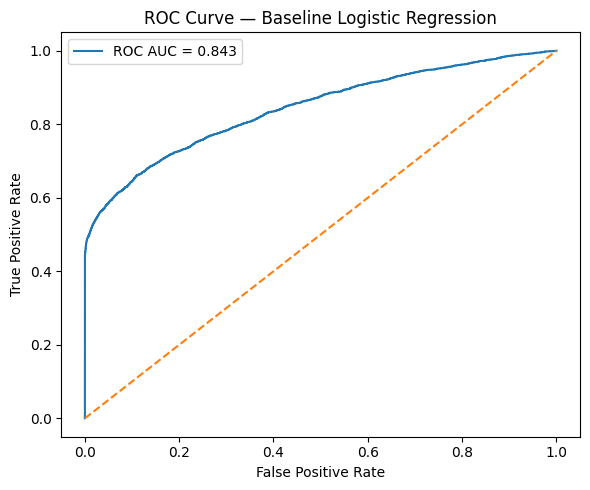

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Baseline Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()


In [84]:
# save the prepared data as pkl
os.makedirs("../artifacts", exist_ok=True)

data_bundle = {
    "X_train": features_train_prepared,
    "X_test": features_test_prepared,
    "y_train": target_train,
    "y_test": target_test
}

joblib.dump(data_bundle, "../artifacts/baseline_dataset.pkl")

['../artifacts/baseline_dataset.pkl']